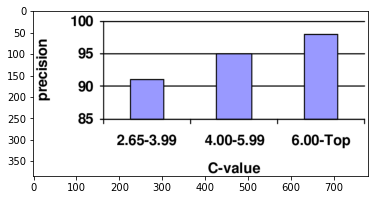

In [1]:
import skimage
from skimage import io
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
import numpy as np
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch
from skimage import measure
import matplotlib.patches as patches
import pytesseract
import re

#showing the example image i will use in this notebook
img = io.imread(r"data\C02-1083-Figure-7-3x.png")
plt.imshow(img)

C:\Users\fabio\.conda\envs\practical_work\lib\site-packages\ipykernel_launcher.py:22: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (1200, 1200, 4) looks like an RGB image


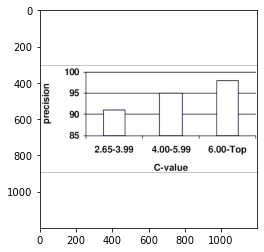

In [2]:
#this is the preprocessing pipeline as described in the paper Euroviz
def preprocessing(image_path):
    
    #opens the image
    img = io.imread(image_path)

    #expands the image to a square shape
    height, width,d = img.shape
    if width == height:
        pass
    elif width > height:
        missing = int((width - height)/2)
        img = np.pad(img,((missing,missing),(0,0),(0,0)))
    else:
        missing = int((height - width)/2)
        img = np.pad(img,((0,0),(missing,missing),(0,0)))
        
    #resizes the image to 1200x1200
    img = resize(img, (1200,1200, 4),anti_aliasing=True)
    
    #binarizing the image, otsus method is not made for color, but i think they did it that way and it looks like its working
    thresh = threshold_otsu(img)
    binary = img > thresh
    img[binary] = int(1)
    return img

plt.imshow(preprocessing(r"data\C02-1083-Figure-7-3x.png"))

In [3]:
#net modeled after:
#https://github.com/domoritz/darknet/blob/master/cfg/writing.cfg
#i also take sigmoid instead of logistic loss because it is almost equal

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
class TheModelClass(nn.Module):
    def __init__(self):
        super(TheModelClass, self).__init__()
        # i decided that all input images will be preprocessed like in the reverse ingeneering paper 
        # to 256x256 such that i dont need the croping layer
        # and i changed the kernel size of the last kernel to get the output of 64x64
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32, kernel_size=[7, 7],stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=32, kernel_size=[3, 3],stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=32, kernel_size=[3, 3],stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32,out_channels=1, kernel_size=[2, 2],stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()
        
    def ramp(self,x):
        #ramp activation fct: https://iopscience.iop.org/article/10.1088/1757-899X/224/1/012054/pdf
        x[x < -1] = -1
        x[x > 1] = 1
        return x
    
    def forward(self, x):
        x = self.ramp(self.conv1(x))
        x = self.ramp(self.conv2(x))
        x = self.ramp(self.conv3(x))
        x = self.sigmoid(self.conv4(x))
        return x

C:\Users\fabio\.conda\envs\practical_work\lib\site-packages\ipykernel_launcher.py:22: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (1200, 1200, 4) looks like an RGB image


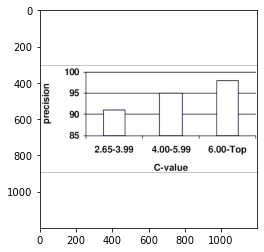

In [25]:
#loading the already trained net
net = torch.load(os.path.join("domoritz_results", "manual_saves", "domoritz_original_cnn.pt"),map_location=torch.device('cpu'))

#here you can see a few images, just comment them out if you want to see something different
processed_img = preprocessing(r"data\C02-1083-Figure-7-3x.png") #works really good
#processed_img = preprocessing(r"data\C02-1161-Figure-3-3x.png") #merges some boxes
#processed_img = preprocessing(r"data\C04-1147-Figure-1-3x.png") #also works well
#processed_img = preprocessing(r"data\D11-1032-Figure-4-3x.png") #also meges some boxes

plt.imshow(processed_img,cmap='gray')

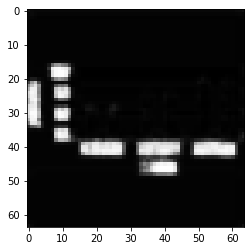

In [26]:
def get_heatmap(processed_img,net):
    """this function calculates the heatmap, by using the parameters:
    processed_img = an image which was processed by the function 'preprocessing'
    net = the net which is used to generate the heatmap"""
    grayscale = skimage.color.rgb2gray(skimage.color.rgba2rgb(processed_img))
    res_gray = resize(grayscale, (255,255),anti_aliasing=True)
    inp = torch.from_numpy(np.array(res_gray.reshape(1,1,255,255),dtype=np.float32))
    heatmap = net(inp)
    return heatmap

heatmap = get_heatmap(processed_img,net)
plt.imshow(heatmap.detach().view(64,64),cmap='gray')

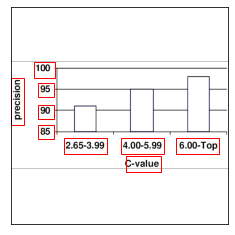

['100 |\n',
 'precision\n',
 '95\n',
 '90\n',
 '&\n',
 '2.65-3.99\n',
 '4.00-5.99\n',
 '6.00-Top\n',
 'C-value\n']

In [27]:
def display_bounding_boxes(heatmap, contour_parameter):
    """this function displays the bounding boxes in a plot
    parameters:
    heatmap = the heatmap
    contour_parameter = parameter, which decides how strict the contour lines are drawn
    returns:
    the text found, as a list
    and displays the bounding boxes"""
    
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    
    big_heatmap = resize(heatmap.detach(), (1,1,1200,1200),anti_aliasing=True)
    r = big_heatmap.reshape(1200,1200)
    contours = measure.find_contours(r,contour_parameter,"low")

    # Display the image
    fig, ax = plt.subplots()
    ax.imshow(processed_img, cmap=plt.cm.gray)
    
    all_text = []
    #plot all bounding boxes 
    for contour in contours:
        #ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
        x = contour[:, 1]
        y = contour[:, 0]
        width = (x.max()-x.min())
        height = (y.max()-y.min())

        if width > 1 and height > 1:
            rect = patches.Rectangle((x.min(), y.min()), width, height, linewidth=1, edgecolor='r', facecolor='none')
            text_img = processed_img[int(y.min()):int(y.max()),int(x.min()):int(x.max())]
            gray = skimage.color.rgb2gray(skimage.color.rgba2rgb(text_img))
            rgb = skimage.color.rgba2rgb(text_img)
            
            #this part just rotates the image and then takes the rotation, in which tesseract is most confident in
            best_conf = -1
            best_angle = 0
            for angle in [0,90,180,270]:
                img = skimage.transform.rotate(rgb,angle,True)
                out = pytesseract.image_to_data((img*255).astype(np.uint8),output_type=pytesseract.Output.DICT,config="--psm 6")
                #calculating average confidence if not -1
                n = 0
                summ = 0
                for val in out["conf"]:
                    if val != "-1":
                        n+=1
                        summ += float(val)
                if n == 0:
                    n = 1
                conf = summ/n

                #saving the best confidence
                if best_conf < conf:
                    best_conf = conf
                    best_angle = angle
                    
            #looking for the content and adding the patch
            rgb = skimage.transform.rotate(rgb,best_angle,True) 
            img_content = pytesseract.image_to_string((rgb*255).astype(np.uint8),config="--psm 6")#6#7 with rotation #11
            ax.add_patch(rect)
            all_text.append(img_content)
            
            
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    return all_text

display_bounding_boxes(heatmap, 0.4)

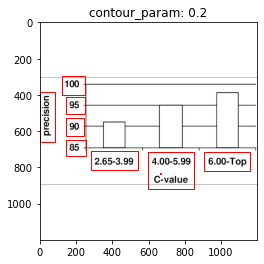

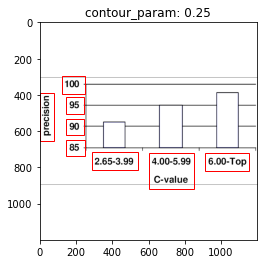

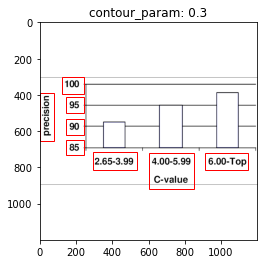

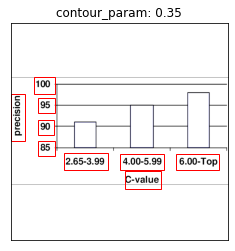

['100\n',
 'precision\n',
 '95\n',
 '90\n',
 '85\n',
 '2.65-3.99\n',
 '4.00-5.99\n',
 '6.00-Top\n',
 'C-value\n']

In [28]:
def display_bounding_boxes_without_param(heatmap):
    """this function is really experimental, i tried to make the choosing of the contour parameter
    automatic, it works here, but more often than not it doesnt work. This function should just show, that it is possible to 
    choose this parameter automatically, even though most of the times it is between 0.2 and 0.4
    
    parameters:
    heatmap = the heatmap
    returns:
    the text found, as a list
    and displays the bounding boxes"""
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    big_heatmap = resize(heatmap.detach(), (1,1,1200,1200),anti_aliasing=True)
    r = big_heatmap.reshape(1200,1200)

    # Display the image and plot all contours found
    splitable = True
    contour_parameter = 0.2
    while splitable:
        contours = measure.find_contours(r,contour_parameter,"low")
        tx = []
        splitable = False
        fig, ax = plt.subplots()
        ax.imshow(processed_img, cmap=plt.cm.gray)
        ax.set_title(f"contour_param: {contour_parameter}")
        for contour in contours:
            #ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
            #if splitable:
                #break
            x = contour[:, 1]
            y = contour[:, 0]
            width = (x.max()-x.min())
            height = (y.max()-y.min())

            if width > 1 and height > 1:
                rect = patches.Rectangle((x.min(), y.min()), width, height, linewidth=1, edgecolor='r', facecolor='none')
                text_img = processed_img[int(y.min()):int(y.max()),int(x.min()):int(x.max())]
                gray = skimage.color.rgb2gray(skimage.color.rgba2rgb(text_img))
                rgb = skimage.color.rgba2rgb(text_img)

                img_content = pytesseract.image_to_string((rgb*255).astype(np.uint8),config="--psm 6")#6#7 with rotation #11

                if "\n" in img_content:
                    if img_content.split("\n")[1] != "":
                        best_conf = -1
                        best_angle = 0
                        for angle in [0,90,180,270]:
                            img = skimage.transform.rotate(rgb,angle,True)
                            out = pytesseract.image_to_data((img*255).astype(np.uint8),output_type=pytesseract.Output.DICT,config="--psm 6")
                            #calculating average confidence if not -1
                            n = 0
                            summ = 0
                            for val in out["conf"]:
                                if val != "-1":
                                    n+=1
                                    summ += float(val)
                            if n == 0:
                                n = 1
                            conf = summ/n
                            #saving the best confidence
                            if best_conf < conf:
                                best_conf = conf
                                best_angle = angle
                        rgb = skimage.transform.rotate(rgb,best_angle,True) 
                        img_content = pytesseract.image_to_string((rgb*255).astype(np.uint8),config="--psm 6")#6#7 with rotation #11
                        if "\n" in img_content:
                            if img_content.split("\n")[1] != "":
                                splitable = True


                tx.append(img_content)
                ax.add_patch(rect)
        contour_parameter += 0.05


    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    return tx


display_bounding_boxes_without_param(heatmap)